In [0]:
import pandas as pd
import dask.dataframe as dd

import folium #open street map
import datetime #Convert to unix time
import calendar

import time #Convert to unix time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import pandas as pd
sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression


In [0]:
from google.colab import drive 
drive.mount('/Data') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /Data


## 1.Create a sample submission

df = pd.read_csv("Data/test.csv");
new = df["key"]
new.shape
new = df[['key']].copy()
new["fare_amount"] = 11.35
new.to_csv("Data/Sample_submission.csv",index=False)

In [0]:
dataDf = pd.read_csv("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/train.csv",nrows=20000000)

In [0]:
dataDf.dtypes
#print(dataDf.shape)

key                  object
fare_amount          object
pickup_datetime      object
pickup_longitude     object
pickup_latitude      object
dropoff_longitude    object
dropoff_latitude     object
passenger_count      object
dtype: object

In [0]:
dataDf.pickup_latitude = pd.to_numeric(dataDf.pickup_latitude,errors='coerce')
dataDf.pickup_longitude = pd.to_numeric(dataDf.pickup_longitude,errors='coerce')
dataDf.dropoff_latitude = pd.to_numeric(dataDf.dropoff_latitude,errors='coerce')
dataDf.dropoff_longitude = pd.to_numeric(dataDf.dropoff_longitude,errors='coerce')
dataDf.passenger_count = pd.to_numeric(dataDf.passenger_count,errors='coerce')
dataDf.fare_amount = pd.to_numeric(dataDf.fare_amount,errors='coerce')

In [0]:
dataDf.dtypes
print(dataDf.shape)

(20000000, 8)


In [0]:
df = dataDf.copy()
df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [0]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26 UTC,-73.986910,40.739538,-73.991381,40.745614,2.0
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00 UTC,-73.961572,40.760283,-73.957438,40.769387,5.0
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00 UTC,-73.979437,40.746517,-73.984195,40.732117,1.0
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00 UTC,-73.964097,40.792508,-73.976422,40.785767,1.0
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00 UTC,-74.003943,40.725670,-73.988915,40.748370,1.0


## 2.Data Preprocessing

#### 1.Latitude and Longitude values

In [0]:
outside_nyc = df[((df.pickup_longitude<= -74.15)|(df.pickup_latitude<=40.5774))|\
                  ((df.pickup_longitude >= -73.7004)|(df.pickup_latitude>=40.9176))|\
                  ((df.dropoff_longitude<= -74.15)|(df.dropoff_latitude<=40.5774))|\
                  ((df.dropoff_longitude >= -73.7004)|(df.dropoff_latitude>=40.9176))]

In [0]:
# pickup and dropoff locations that are outside NewYork are considere as outliers for our analysis

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_locations = outside_nyc.head(1000)

for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        if (((j.pickup_longitude<= -74.15)|(j.pickup_latitude<=40.5774))|\
                  ((j.pickup_longitude >= -73.7004)|(j.pickup_latitude>=40.9176))):
            folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
        if (((j.dropoff_longitude<= -74.15)|(j.dropoff_latitude<=40.5774))|\
                  ((j.dropoff_longitude >= -73.7004)|(j.dropoff_latitude>=40.9176))):
            folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
            
map_osm

In [0]:
def get_map(data):
    map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
    sample_locations = data.head(1000)

    for i,j in sample_locations.iterrows():
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
            
    return map_osm
    

In [0]:
#drop rows with outliers in lattitude and longitude values

df_p1 = df[((df.pickup_longitude>= -74.15)&(df.pickup_latitude>=40.5774))&\
                  ((df.pickup_longitude <= -73.7004)&(df.pickup_latitude<=40.9176))&\
                  ((df.dropoff_longitude>= -74.15)&(df.dropoff_latitude>=40.5774))&\
                  ((df.dropoff_longitude <= -73.7004)&(df.dropoff_latitude<=40.9176))]

In [0]:
# pickup and dropoff locations after removing outliers

maps = get_map(df_p1)
maps

In [0]:
df_p1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26 UTC,-73.986910,40.739538,-73.991381,40.745614,2.0
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00 UTC,-73.961572,40.760283,-73.957438,40.769387,5.0
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00 UTC,-73.979437,40.746517,-73.984195,40.732117,1.0
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00 UTC,-73.964097,40.792508,-73.976422,40.785767,1.0
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00 UTC,-74.003943,40.725670,-73.988915,40.748370,1.0


In [0]:
print(df_p1.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [0]:
df_p1.shape

(19519084, 8)

#### 2.Trip Distance

In [0]:
# creating a new feature distance of travell using the latitude and longitude data
import geopy.distance

dist = []

for i in range(df_p1.shape[0]):
  cord_1 = (df_p1.pickup_latitude.values[i],df_p1.pickup_longitude.values[i])    
  cord_2 = (df_p1.dropoff_latitude.values[i],df_p1.dropoff_longitude.values[i])
  dist.append(geopy.distance.vincenty(cord_1,cord_2).miles)

df_p1["trip_distance"] = dist

In [0]:

df_p1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26,-73.986910,40.739538,-73.991381,40.745614,2.0,0.480456,2010-10-20,20,23,3,10,2010
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00,-73.961572,40.760283,-73.957438,40.769387,5.0,0.664589,2009-12-30,30,10,3,12,2009
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00,-73.979437,40.746517,-73.984195,40.732117,1.0,1.024537,2012-07-20,20,11,5,7,2012
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00,-73.964097,40.792508,-73.976422,40.785767,1.0,0.796357,2011-05-31,31,11,2,5,2011
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00,-74.003943,40.725670,-73.988915,40.748370,1.0,1.753747,2010-05-25,25,17,2,5,2010


In [0]:
df_p1 = df_p1[df_p1.trip_distance>0]

In [0]:
df_p1[df_p1.trip_distance==0].shape

(0, 21)

#### 3.Pickup datetime

In [0]:
df_p1['pickup_datetime'] = pd.to_datetime(df_p1['pickup_datetime'] ,format='%Y-%m-%d %H:%M:%S UTC' )

df_p1['pickup_date']= df_p1['pickup_datetime'].dt.date
df_p1['pickup_day']=df_p1['pickup_datetime'].apply(lambda x:x.day)
df_p1['pickup_hour']=df_p1['pickup_datetime'].apply(lambda x:x.hour)
df_p1['pickup_day_of_week']=df_p1['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
df_p1['pickup_month']=df_p1['pickup_datetime'].apply(lambda x:x.month)
df_p1['pickup_year']=df_p1['pickup_datetime'].apply(lambda x:x.year)

df_p1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26,-73.986910,40.739538,-73.991381,40.745614,2.0,0.480456,2010-10-20,20,23,Wednesday,10,2010
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00,-73.961572,40.760283,-73.957438,40.769387,5.0,0.664589,2009-12-30,30,10,Wednesday,12,2009
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00,-73.979437,40.746517,-73.984195,40.732117,1.0,1.024537,2012-07-20,20,11,Friday,7,2012
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00,-73.964097,40.792508,-73.976422,40.785767,1.0,0.796357,2011-05-31,31,11,Tuesday,5,2011
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00,-74.003943,40.725670,-73.988915,40.748370,1.0,1.753747,2010-05-25,25,17,Tuesday,5,2010


In [0]:
#encoding day of the week to numbers
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
  

In [0]:

   
df_p1['pickup_day_of_week']=df_p1['pickup_day_of_week'].apply(lambda x:encodeDays(x))

df_p1.head()

#timeDf.head()
#timeDf.shape

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26,-73.986910,40.739538,-73.991381,40.745614,2.0,0.480456,2010-10-20,20,23,3,10,2010
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00,-73.961572,40.760283,-73.957438,40.769387,5.0,0.664589,2009-12-30,30,10,3,12,2009
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00,-73.979437,40.746517,-73.984195,40.732117,1.0,1.024537,2012-07-20,20,11,5,7,2012
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00,-73.964097,40.792508,-73.976422,40.785767,1.0,0.796357,2011-05-31,31,11,2,5,2011
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00,-74.003943,40.725670,-73.988915,40.748370,1.0,1.753747,2010-05-25,25,17,2,5,2010


In [0]:

print(df_p1.isnull().sum())
df_p1.shape

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
trip_distance         0
pickup_date           0
pickup_day            0
pickup_hour           0
pickup_day_of_week    0
pickup_month          0
pickup_year           0
dtype: int64


(19519084, 15)

#### 4.Fare amount

In [0]:
#checking negative price values
df_p1.loc[df_p1['fare_amount']<0].shape



(741, 15)

In [0]:
#Minimum fare amount is $2.5


df_p1=df_p1[(df_p1['fare_amount']>=2.5) & (df_p1['fare_amount']<=300)]
##df_p1.shape

df_p1.loc[df_p1['fare_amount']<0].shape

(0, 15)

#### 5.Passenger Count

In [0]:
#checking negative passenger count
df_p1.loc[df_p1['passenger_count']<=0].shape


(69121, 8)

In [0]:
df_p1 = df_p1.loc[df_p1['passenger_count']>0]
df_p1[df_p1['passenger_count']<0].shape


(0, 15)

In [0]:
df_p1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26,-73.986910,40.739538,-73.991381,40.745614,2.0,0.480456,2010-10-20,20,23,3,10,2010
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00,-73.961572,40.760283,-73.957438,40.769387,5.0,0.664589,2009-12-30,30,10,3,12,2009
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00,-73.979437,40.746517,-73.984195,40.732117,1.0,1.024537,2012-07-20,20,11,5,7,2012
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00,-73.964097,40.792508,-73.976422,40.785767,1.0,0.796357,2011-05-31,31,11,2,5,2011
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00,-74.003943,40.725670,-73.988915,40.748370,1.0,1.753747,2010-05-25,25,17,2,5,2010


#### 6.Weekends

In [0]:
# Sunday Saturday and Friday are considered as weekends. The coulm will have a value of 1 for pickup day of week 5,0,6
def isWeekend(data):
  conditions = [((data['pickup_day_of_week']==0) | (data['pickup_day_of_week']==5) | (data['pickup_day_of_week']==6))]
  choices  = [1];
  data["isWeekend"] = np.select(conditions,choices,default=0)
  return data

In [0]:
df_p1 = isWeekend(df_p1)


In [0]:
df_p1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,IsWeekend
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26,-73.986910,40.739538,-73.991381,40.745614,2.0,0.480456,2010-10-20,20,23,3,10,2010,0
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00,-73.961572,40.760283,-73.957438,40.769387,5.0,0.664589,2009-12-30,30,10,3,12,2009,0
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00,-73.979437,40.746517,-73.984195,40.732117,1.0,1.024537,2012-07-20,20,11,5,7,2012,1
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00,-73.964097,40.792508,-73.976422,40.785767,1.0,0.796357,2011-05-31,31,11,2,5,2011,0
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00,-74.003943,40.725670,-73.988915,40.748370,1.0,1.753747,2010-05-25,25,17,2,5,2010,0


#### 7.Surge Hours

In [0]:
def isSurge(data):
  conditions = [((data['pickup_hour']>=3) & (data['pickup_hour']<=6))]
  choices  = [1];
  data["isSurge"] = np.select(conditions,choices,default=0)
  return data

### 8.Adding airport columns


In [0]:
JFK={'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931}
JFK_center=[40.6437,-73.7900]
# Get all pickups to JFK
JFK_data=df_p1.loc[(df_p1.pickup_latitude>=JFK['min_lat']) & (df_p1.pickup_latitude<=JFK['max_lat'])]
JFK_data=JFK_data.loc[(df_p1.pickup_longitude>=JFK['min_lng']) & (df_p1.pickup_longitude<=JFK['max_lng'])]

print("Number of Trips with Pickups from JFK",JFK_data.shape[0])

JFK_dropoff=df_p1.loc[(df_p1.dropoff_latitude>=JFK['min_lat']) & (df_p1.dropoff_latitude<=JFK['max_lat'])]
JFK_dropoff=JFK_dropoff.loc[(df_p1.dropoff_longitude>=JFK['min_lng']) & (df_p1.dropoff_longitude<=JFK['max_lng'])]

print("Number of Trips with Dropoffs to JFK",JFK_dropoff.shape[0])


Number of Trips with Pickups from JFK 387974
Number of Trips with Dropoffs to JFK 248158


Text(0.5, 1.0, 'Fare Amount Distribution')

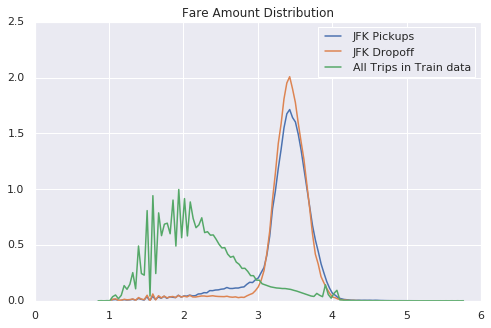

In [0]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(JFK_data['fare_amount'].values),label='JFK Pickups')
sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label='JFK Dropoff')
sns.kdeplot(np.log(df_p1['fare_amount'].values),label='All Trips in Train data')
plt.title("Fare Amount Distribution")


In [0]:
nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}



def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0

In [0]:
df_p1['is_pickup_JFK']=df_p1.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
df_p1['is_dropoff_JFK']=df_p1.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

In [0]:
df_p1['is_pickup_EWR']=df_p1.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
df_p1['is_dropoff_EWR']=df_p1.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

In [0]:
df_p1['is_pickup_la_guardia']=df_p1.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
df_p1['is_dropoff_la_guardia']=df_p1.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

In [0]:
df_p1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_la_guardia,is_dropoff_la_guardia
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26,-73.986910,40.739538,-73.991381,40.745614,2.0,0.480456,2010-10-20,20,23,3,10,2010,0,0,0,0,0,0
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00,-73.961572,40.760283,-73.957438,40.769387,5.0,0.664589,2009-12-30,30,10,3,12,2009,0,0,0,0,0,0
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00,-73.979437,40.746517,-73.984195,40.732117,1.0,1.024537,2012-07-20,20,11,5,7,2012,0,0,0,0,0,0
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00,-73.964097,40.792508,-73.976422,40.785767,1.0,0.796357,2011-05-31,31,11,2,5,2011,0,0,0,0,0,0
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00,-74.003943,40.725670,-73.988915,40.748370,1.0,1.753747,2010-05-25,25,17,2,5,2010,0,0,0,0,0,0


In [0]:
df_p1.to_csv("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/train_proc.csv",index=False)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_la_guardia,is_dropoff_la_guardia
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26,-73.986910,40.739538,-73.991381,40.745614,2.0,0.480456,2010-10-20,20,23,3,10,2010,0,0,0,0,0,0
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00,-73.961572,40.760283,-73.957438,40.769387,5.0,0.664589,2009-12-30,30,10,3,12,2009,0,0,0,0,0,0
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00,-73.979437,40.746517,-73.984195,40.732117,1.0,1.024537,2012-07-20,20,11,5,7,2012,0,0,0,0,0,0
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00,-73.964097,40.792508,-73.976422,40.785767,1.0,0.796357,2011-05-31,31,11,2,5,2011,0,0,0,0,0,0
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00,-74.003943,40.725670,-73.988915,40.748370,1.0,1.753747,2010-05-25,25,17,2,5,2010,0,0,0,0,0,0


### 9.Store Preprocessed data

In [0]:

df_p1.to_csv("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/train_proc.csv",index=False)

In [0]:
df_p1 = pd.read_csv("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/train_proc.csv")


In [0]:
df_p1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,2010-10-20 23:26:26.0000003,4.5,2010-10-20 23:26:26,-73.986910,40.739538,-73.991381,40.745614,2.0,0.480456,2010-10-20,20,23,3,10,2010
1,2009-12-30 10:56:00.00000075,4.1,2009-12-30 10:56:00,-73.961572,40.760283,-73.957438,40.769387,5.0,0.664589,2009-12-30,30,10,3,12,2009
2,2012-07-20 11:24:00.00000022,6.1,2012-07-20 11:24:00,-73.979437,40.746517,-73.984195,40.732117,1.0,1.024537,2012-07-20,20,11,5,7,2012
3,2011-05-31 11:29:00.000000136,4.9,2011-05-31 11:29:00,-73.964097,40.792508,-73.976422,40.785767,1.0,0.796357,2011-05-31,31,11,2,5,2011
4,2010-05-25 17:57:00.000000145,6.5,2010-05-25 17:57:00,-74.003943,40.725670,-73.988915,40.748370,1.0,1.753747,2010-05-25,25,17,2,5,2010


## 3.Exploratory Data Analysis

#### 1.PDF

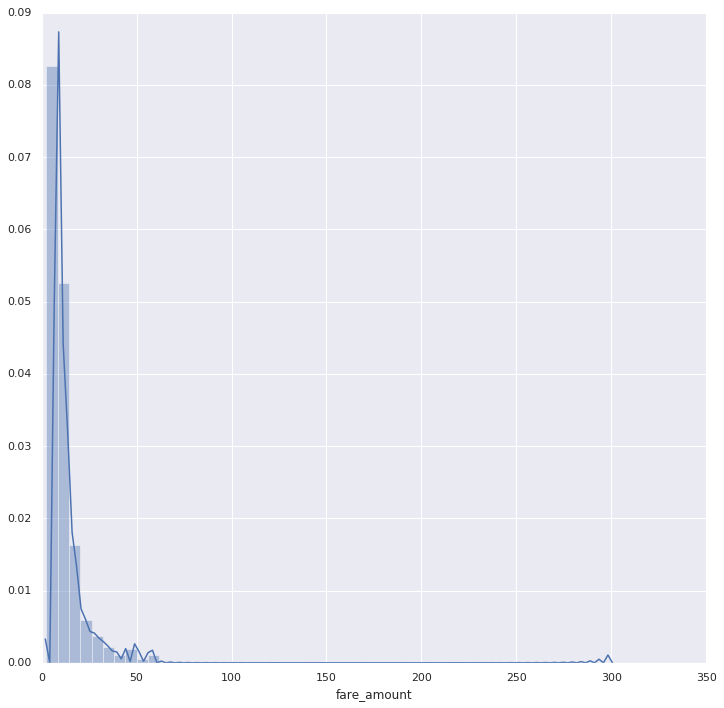

In [0]:
#sns.distplot(df_p1['pickup_year']);
#plt.axvline(0, color="k", linestyle="--");
sns.FacetGrid(df_p1,size=10) \
   .map(sns.distplot, "fare_amount") \
   .add_legend();
plt.show();

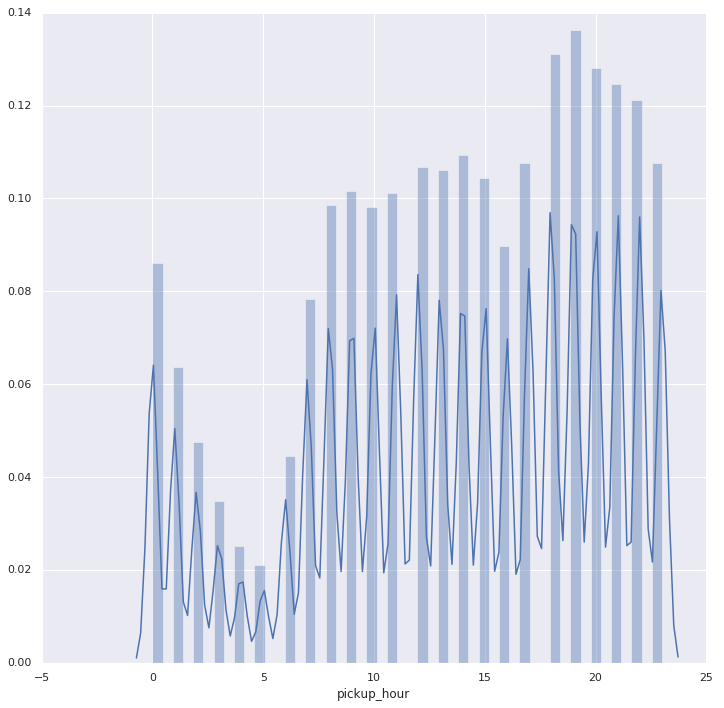

In [0]:
sns.FacetGrid(df_p1,size=10) \
   .map(sns.distplot, "pickup_hour") \
   .add_legend();
plt.show();

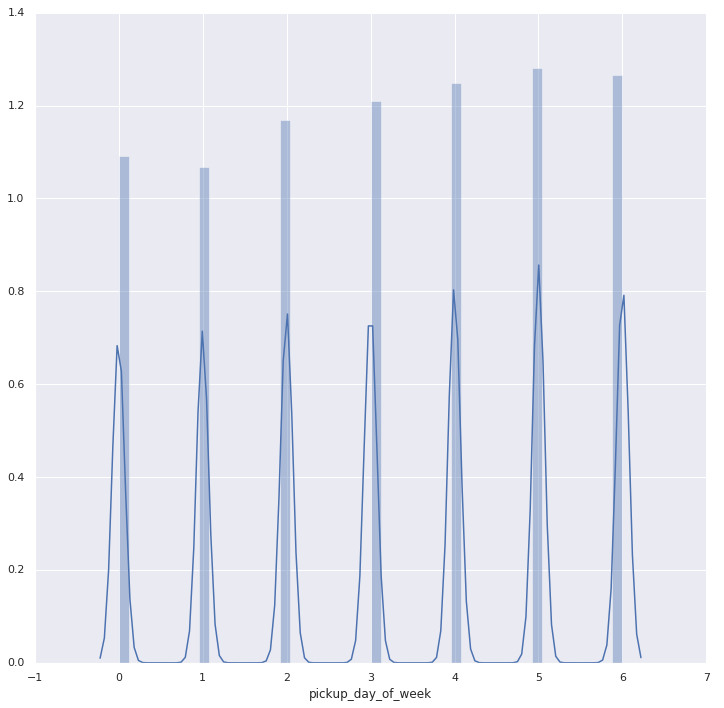

In [0]:
sns.FacetGrid(df_p1,size=10) \
   .map(sns.distplot, "pickup_day_of_week") \
   .add_legend();
plt.show();

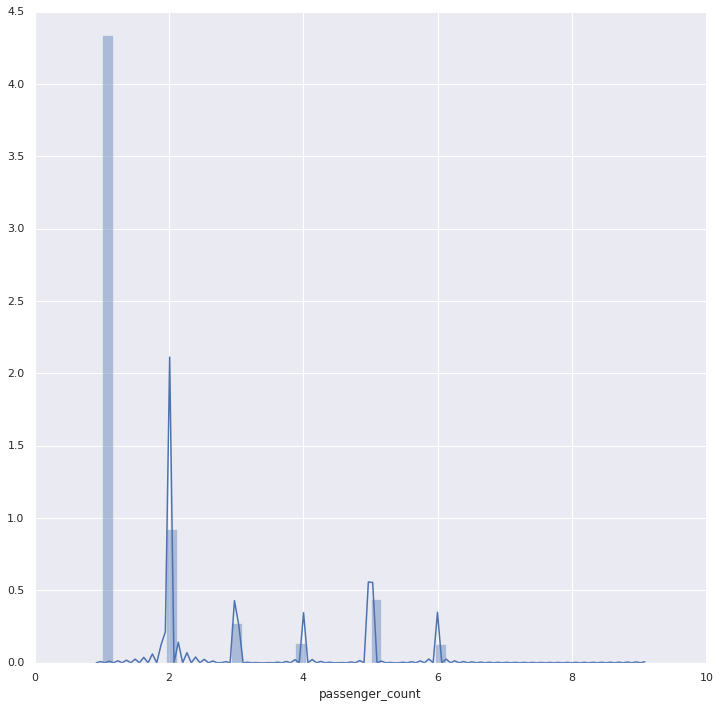

In [0]:
sns.FacetGrid(df_p1,size=10) \
   .map(sns.distplot, "passenger_count") \
   .add_legend();
plt.show();

#### 2.Scatter plots

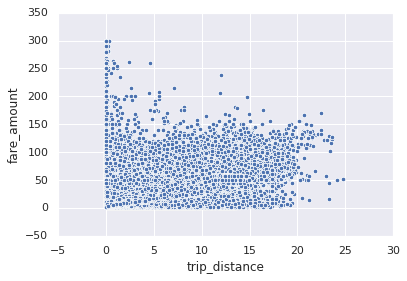

In [0]:
sns.scatterplot(x='trip_distance',y='fare_amount',data=df_p1)


In [0]:
#df_p1.loc[df_p1['fare_amount']>300].shape

In [0]:
#df_p1=df_p1[(df_p1['fare_amount']<500)]

#sns.scatterplot(x='trip_distance',y='fare_amount',data=df_p1)

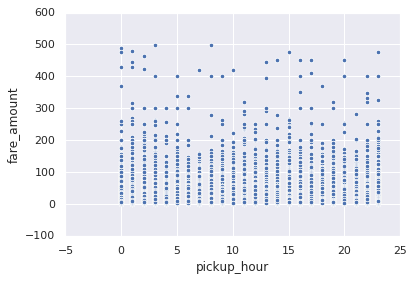

In [0]:
sns.scatterplot(x='pickup_hour',y='fare_amount',data=df_p1)


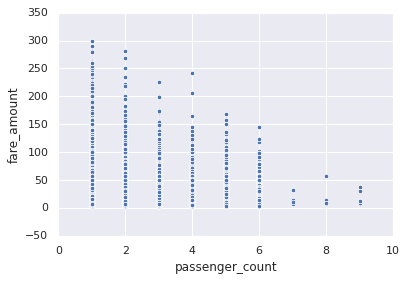

In [0]:

df_p1=df_p1[(df_p1['passenger_count']<10)]

sns.scatterplot(x='passenger_count',y='fare_amount',data=df_p1)


### 3.Bar Graphs

Text(0.5, 1.0, 'Avg Fare Amount over Years')

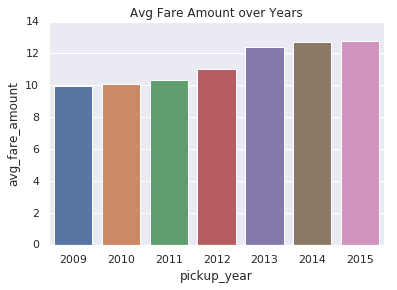

In [0]:
pickup_year_avg_fares =df_p1.groupby(['pickup_year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_year',y='avg_fare_amount',data=pickup_year_avg_fares).set_title("Avg Fare Amount over Years")

Text(0.5, 1.0, 'Avg Fare Amount over Hours')

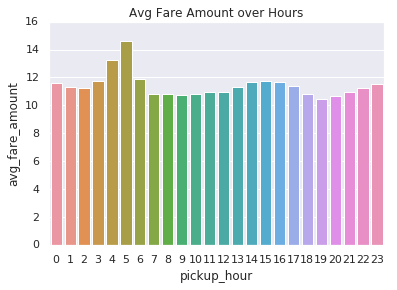

In [0]:
avg_fares =df_p1.groupby(['pickup_hour'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_hour',y='avg_fare_amount',data=avg_fares).set_title("Avg Fare Amount over Hours")

Text(0.5, 1.0, 'Number of trips over Hours')

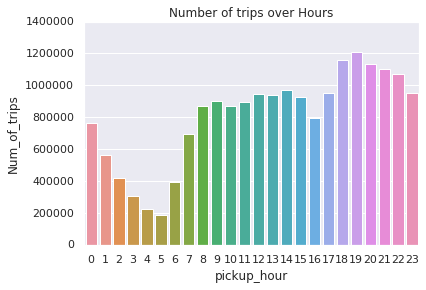

In [0]:
avg_fares =df_p1.groupby(['pickup_hour'])['key'].count().reset_index().rename(columns={'key':'Num_of_trips'})
sns.barplot(x='pickup_hour',y='Num_of_trips',data=avg_fares).set_title("Number of trips over Hours")

Text(0.5, 1.0, 'Avg Fare Amount over Day of week')

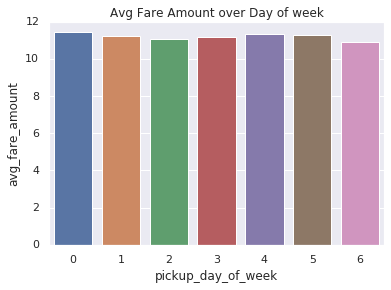

In [0]:
avg_fares =df_p1.groupby(['pickup_day_of_week'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_day_of_week',y='avg_fare_amount',data=avg_fares).set_title("Avg Fare Amount over Day of week")

Text(0.5, 1.0, 'Number of trips over day_of_week')

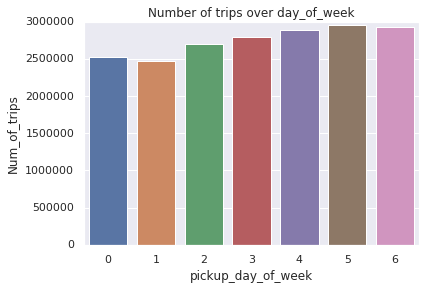

In [0]:
avg_fares =df_p1.groupby(['pickup_day_of_week'])['key'].count().reset_index().rename(columns={'key':'Num_of_trips'})
sns.barplot(x='pickup_day_of_week',y='Num_of_trips',data=avg_fares).set_title("Number of trips over day_of_week")

Text(0.5, 1.0, 'Avg Fare Amount over Months')

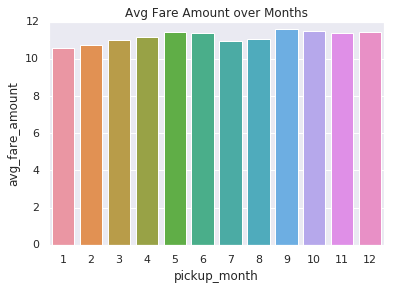

In [0]:
avg_fares =df_p1.groupby(['pickup_month'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_month',y='avg_fare_amount',data=avg_fares).set_title("Avg Fare Amount over Months")

Text(0.5, 1.0, 'Number of trips over pickup_month')

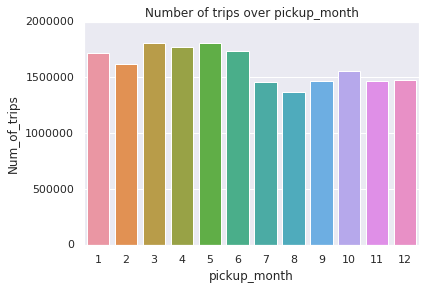

In [0]:
avg_fares =df_p1.groupby(['pickup_month'])['key'].count().reset_index().rename(columns={'key':'Num_of_trips'})
sns.barplot(x='pickup_month',y='Num_of_trips',data=avg_fares).set_title("Number of trips over pickup_month")

Text(0.5, 1.0, 'Avg Fare Amount over passenger count')

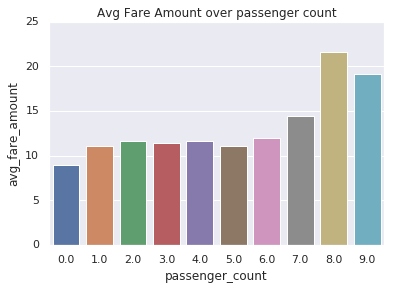

In [0]:
avg_fares =df_p1.groupby(['passenger_count'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='passenger_count',y='avg_fare_amount',data=avg_fares).set_title("Avg Fare Amount over passenger count")

Text(0.5, 1.0, 'Avg Fare Amount over pickup day')

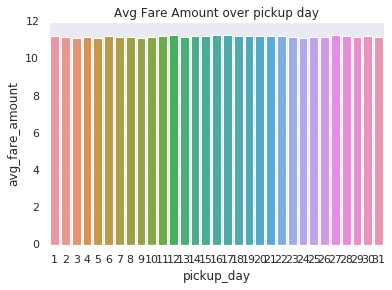

In [0]:
avg_fares =df_p1.groupby(['pickup_day'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='pickup_day',y='avg_fare_amount',data=avg_fares).set_title("Avg Fare Amount over pickup day")

In [0]:
df_p1.columns
df_p1.shape

(19518326, 15)

## 4.Process test data

In [0]:
testDf = pd.read_csv("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/test.csv")

In [0]:
testDf.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-01-01 00:01:04.0000003,2009-01-01 00:01:04 UTC,-73.972484,40.742743,-73.918937,40.764496,1
1,2009-01-01 00:01:26.0000001,2009-01-01 00:01:26 UTC,-73.985850,40.722826,-73.986301,40.739347,1
2,2009-01-01 00:04:42.0000001,2009-01-01 00:04:42 UTC,-73.988917,40.740142,-73.982769,40.777291,1
3,2009-01-01 00:04:54.0000001,2009-01-01 00:04:54 UTC,-73.977163,40.764490,-73.914474,40.771575,1
4,2009-01-01 00:04:59.0000004,2009-01-01 00:04:59 UTC,-73.948849,40.778003,-73.977678,40.748692,2


In [0]:
testDf.shape

(11084772, 7)

In [0]:
# split datetime into year month and week

testDf['pickup_datetime'] = pd.to_datetime(testDf['pickup_datetime'] ,format='%Y-%m-%d %H:%M:%S UTC' )

testDf['pickup_date']= testDf['pickup_datetime'].dt.date
testDf['pickup_day']=testDf['pickup_datetime'].apply(lambda x:x.day)
testDf['pickup_hour']=testDf['pickup_datetime'].apply(lambda x:x.hour)
testDf['pickup_day_of_week']=testDf['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
testDf['pickup_month']=testDf['pickup_datetime'].apply(lambda x:x.month)
testDf['pickup_year']=testDf['pickup_datetime'].apply(lambda x:x.year)
testDf['pickup_day_of_week']=testDf['pickup_day_of_week'].apply(lambda x:encodeDays(x))


testDf.head()


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,2009-01-01 00:01:04.0000003,2009-01-01 00:01:04,-73.972484,40.742743,-73.918937,40.764496,1,2009-01-01,1,0,4,1,2009
1,2009-01-01 00:01:26.0000001,2009-01-01 00:01:26,-73.985850,40.722826,-73.986301,40.739347,1,2009-01-01,1,0,4,1,2009
2,2009-01-01 00:04:42.0000001,2009-01-01 00:04:42,-73.988917,40.740142,-73.982769,40.777291,1,2009-01-01,1,0,4,1,2009
3,2009-01-01 00:04:54.0000001,2009-01-01 00:04:54,-73.977163,40.764490,-73.914474,40.771575,1,2009-01-01,1,0,4,1,2009
4,2009-01-01 00:04:59.0000004,2009-01-01 00:04:59,-73.948849,40.778003,-73.977678,40.748692,2,2009-01-01,1,0,4,1,2009


In [0]:
testDf['is_pickup_JFK']=testDf.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
testDf['is_dropoff_JFK']=testDf.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

testDf['is_pickup_EWR']=testDf.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
testDf['is_dropoff_EWR']=testDf.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)


In [0]:
testDf.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,2009-01-01 00:01:04.0000003,2009-01-01 00:01:04,-73.972484,40.742743,-73.918937,40.764496,1,2009-01-01,1,0,4,1,2009
1,2009-01-01 00:01:26.0000001,2009-01-01 00:01:26,-73.985850,40.722826,-73.986301,40.739347,1,2009-01-01,1,0,4,1,2009
2,2009-01-01 00:04:42.0000001,2009-01-01 00:04:42,-73.988917,40.740142,-73.982769,40.777291,1,2009-01-01,1,0,4,1,2009
3,2009-01-01 00:04:54.0000001,2009-01-01 00:04:54,-73.977163,40.764490,-73.914474,40.771575,1,2009-01-01,1,0,4,1,2009
4,2009-01-01 00:04:59.0000004,2009-01-01 00:04:59,-73.948849,40.778003,-73.977678,40.748692,2,2009-01-01,1,0,4,1,2009


In [0]:
# create a trip distance column for test data

dist = []

for i in range(testDf.shape[0]):
  cord_1 = (testDf.pickup_latitude.values[i],testDf.pickup_longitude.values[i])    
  cord_2 = (testDf.dropoff_latitude.values[i],testDf.dropoff_longitude.values[i])
  try:
    dist.append(geopy.distance.vincenty(cord_1,cord_2).miles)
  except ValueError:
    dist.append(0)
 
testDf["trip_distance"] = dist

In [0]:
testDf['trip_distance'][testDf.trip_distance!=0].count()


10767495

In [0]:
testDf.to_csv("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/test_proc.csv",index=False)

## 5.Model Building

In [0]:
#load preprocessed train and test data

df_p1 = pd.read_csv("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/train_proc.csv")
testDf = pd.read_csv("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/test_proc.csv")

In [0]:
testDf['is_pickup_JFK']=testDf.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
testDf['is_dropoff_JFK']=testDf.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

testDf['is_pickup_EWR']=testDf.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
testDf['is_dropoff_EWR']=testDf.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

In [0]:
testDf.dropoff_latitude.fillna(0, inplace=True)
testDf.dropoff_longitude.fillna(0, inplace=True)
testDf.isnull().sum()

key                   0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
trip_distance         0
pickup_date           0
pickup_day            0
pickup_hour           0
pickup_day_of_week    0
pickup_month          0
pickup_year           0
is_pickup_JFK         0
is_dropoff_JFK        0
is_pickup_EWR         0
is_dropoff_EWR        0
dtype: int64

In [0]:
testDf.to_csv("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/test_proc.csv",index=False)
testDf.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR
0,2009-01-01 00:01:04.0000003,2009-01-01 00:01:04,-73.972484,40.742743,-73.918937,40.764496,1,3.185589,2009-01-01,1,0,4,1,2009,0,0,0,0
1,2009-01-01 00:01:26.0000001,2009-01-01 00:01:26,-73.985850,40.722826,-73.986301,40.739347,1,1.140236,2009-01-01,1,0,4,1,2009,0,0,0,0
2,2009-01-01 00:04:42.0000001,2009-01-01 00:04:42,-73.988917,40.740142,-73.982769,40.777291,1,2.583603,2009-01-01,1,0,4,1,2009,0,0,0,0
3,2009-01-01 00:04:54.0000001,2009-01-01 00:04:54,-73.977163,40.764490,-73.914474,40.771575,1,3.324931,2009-01-01,1,0,4,1,2009,0,0,0,0
4,2009-01-01 00:04:59.0000004,2009-01-01 00:04:59,-73.948849,40.778003,-73.977678,40.748692,2,2.525557,2009-01-01,1,0,4,1,2009,0,0,0,0


In [0]:
#features = ["trip_distance","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","pickup_year","pickup_hour","passenger_count","is_pickup_JFK","is_dropoff_JFK","is_pickup_EWR","is_dropoff_EWR"]
features = ["trip_distance","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","pickup_year","pickup_hour","pickup_month","passenger_count","pickup_day_of_week","is_pickup_JFK","is_dropoff_JFK","is_pickup_EWR","is_dropoff_EWR"]
#features = ["trip_distance","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","pickup_year","pickup_hour","pickup_month","passenger_count","pickup_day_of_week"]
trainDf_final = df_p1.loc[:,features]
fareDf_train = df_p1.loc[:,["fare_amount"]]
fareDf_train.head()

,fare_amount
0,4.5
1,4.1
2,6.1
3,4.9
4,6.5


In [0]:
print(trainDf_final.shape)
print(fareDf_train.shape)

(19249515, 14)
(19249515, 1)


In [0]:
trainDf_final.columns

Index(['trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_year', 'pickup_hour',
       'pickup_month', 'passenger_count', 'pickup_day_of_week',
       'is_pickup_JFK', 'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR'],
      dtype='object')

In [0]:
testDf_final = testDf.loc[:,features]
testDf_final.columns

Index(['trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_year', 'pickup_hour',
       'pickup_month', 'passenger_count', 'pickup_day_of_week',
       'is_pickup_JFK', 'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR'],
      dtype='object')

In [0]:
print(testDf_final.shape)
testDf_final.head()

(11084772, 14)


,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_year,pickup_hour,pickup_month,passenger_count,pickup_day_of_week,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR
0,3.185589,-73.972484,40.742743,-73.918937,40.764496,2009,0,1,1,4,0,0,0,0
1,1.140236,-73.985850,40.722826,-73.986301,40.739347,2009,0,1,1,4,0,0,0,0
2,2.583603,-73.988917,40.740142,-73.982769,40.777291,2009,0,1,1,4,0,0,0,0
3,3.324931,-73.977163,40.764490,-73.914474,40.771575,2009,0,1,1,4,0,0,0,0
4,2.525557,-73.948849,40.778003,-73.977678,40.748692,2009,0,1,2,4,0,0,0,0


In [0]:
trainDf_final  = trainDf_final.loc[:15000000,:]
fareDf_train =  fareDf_train.loc[:15000000:,:]

In [0]:
#function to create dataframe in submission format from predicted values of fares

def createSubmission(testDf,pred_values):
  submission = pd.DataFrame(
      {'key': testDf.key, 'fare_amount': pred_values[:]},
      columns = ['key', 'fare_amount'])
  return submission


In [0]:
testDf_final.dropna()
trainDf_final.dropna()
fareDf_train.dropna()

,index,fare_amount
0,0,4.5
1,1,4.1
2,2,6.1
3,3,4.9
4,4,6.5
...,...,...
4999996,4999996,5.5
4999997,4999997,21.5
4999998,4999998,19.3
4999999,4999999,14.9


In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
trainDf_final_scaled = sc.fit_transform(trainDf_final)
testDf_final_scaled = sc.transform(testDf_final)

In [0]:
type(trainDf_final_scaled)
testDf_final.mean()

trip_distance           12.315319
pickup_longitude       -72.507652
pickup_latitude         39.916024
dropoff_longitude      -72.510279
dropoff_latitude        39.921237
pickup_year           2011.740003
pickup_hour             13.509426
pickup_month             6.266189
passenger_count          1.685516
pickup_day_of_week       3.123793
is_pickup_JFK                 NaN
is_dropoff_JFK                NaN
is_pickup_EWR                 NaN
is_dropoff_EWR                NaN
isSurge                       NaN
dtype: float64

In [0]:
trainDf_final = trainDf_final.reset_index()
testDf_final = testDf_final.reset_index()
fareDf_train = fareDf_train.reset_index()

In [0]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=300, random_state=0)
regressor.fit(trainDf_final, fareDf_train)
fare_predDf = regressor.predict(testDf_final)

In [0]:
##run this

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(trainDf_final,fareDf_train)
fare_pred = rf.predict(testDf_final)

ValueError: ignored

In [0]:
submission  = createSubmission(testDf,fare_pred)

submission.to_csv('/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/submission_rforest_new.csv', index = False)
print("Dimension of submission :",submission.shape)
submission.head()

### 1.XGboost

In [0]:
#testDf_final['trip_distance'][testDf_final.trip_distance==0].count()
testDf_final.shape

(11084772, 14)

In [0]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.15,
                max_depth = 3, alpha = 10, n_estimators = 100)

xg_reg.fit(trainDf_final,fareDf_train)
fare_pred = xg_reg.predict(testDf_final)

[01:55:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:55:21] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[01:55:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:55:21] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [0]:
##new xgboost
import xgboost as xgb
xg_reg = xgb.XGBRegressor(n_estimator=201,max_depth=17,random_state=0)

xg_reg.fit(trainDf_final,fareDf_train)
fare_pred = xg_reg.predict(testDf_final)


[17:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:41:39] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [0]:
submission  = createSubmission(testDf,fare_pred)

submission.to_csv('/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/submission_xgboost_new.csv', index = False)
print("Dimension of submission :",submission.shape)
submission.head()

Dimension of submission : (11084772, 2)


,key,fare_amount
0,2009-01-01 00:01:04.0000003,15.946864
1,2009-01-01 00:01:26.0000001,6.703885
2,2009-01-01 00:04:42.0000001,10.602039
3,2009-01-01 00:04:54.0000001,14.378499
4,2009-01-01 00:04:59.0000004,9.608433


In [0]:
fare_pred.shape

(11084772,)

In [0]:
trainDf_final.head()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_year,pickup_hour,pickup_month,passenger_count,pickup_day_of_week
0,0.480456,-73.986910,40.739538,-73.991381,40.745614,2010,23,10,2.0,3
1,0.664589,-73.961572,40.760283,-73.957438,40.769387,2009,10,12,5.0,3
2,1.024537,-73.979437,40.746517,-73.984195,40.732117,2012,11,7,1.0,5
3,0.796357,-73.964097,40.792508,-73.976422,40.785767,2011,11,5,1.0,2
4,1.753747,-74.003943,40.725670,-73.988915,40.748370,2010,17,5,1.0,2


In [0]:
import xgboost as xgb

matrix_train = xgb. DMatrix(trainDf_final,fareDf_train);
model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=5000)
fare_pred = model.predict(xgb.DMatrix(testDf_final), ntree_limit = model.best_ntree_limit)

[05:56:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:18] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


### 2.LightGBM

In [0]:
import lightgbm as lgb
lgb_train = lgb.Dataset(trainDf_final, label=fareDf_train)
params = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'learning_rate': 0.1,
    'num_iterations' : 300,
    'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20)

In [0]:
fare_pred = gbm.predict(testDf_final, num_iteration=gbm.best_iteration)

In [0]:
gbm.save_model("/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/model_lgbm.txt")

In [0]:
trainDf_final.head()
fareDf_train.head()
testDf_final.head()
print(trainDf_final.shape)
print(fareDf_train.shape)
print(testDf_final.shape)

(15000001, 14)
(15000001, 1)
(11084772, 14)


In [0]:
import lightgbm as lgb

train_data=lgb.Dataset(trainDf_final,label=fareDf_train)
param = {'num_leaves':31, 'num_trees':5000,'objective':'regression'}
param['metric'] = 'l2_root'
num_round=2000
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=20, early_stopping_rounds=20,stratified=False)
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))
fare_pred = lgb_bst.predict(testDf_final)

[20]	cv_agg's rmse: 3.79226 + 0.0191572
[40]	cv_agg's rmse: 3.48557 + 0.0197142
[60]	cv_agg's rmse: 3.40883 + 0.0187359
[80]	cv_agg's rmse: 3.36422 + 0.0194716
[100]	cv_agg's rmse: 3.33365 + 0.0203588
[120]	cv_agg's rmse: 3.31013 + 0.0197031
[140]	cv_agg's rmse: 3.28996 + 0.0198652
[160]	cv_agg's rmse: 3.27566 + 0.0194122
[180]	cv_agg's rmse: 3.2629 + 0.0191564
[200]	cv_agg's rmse: 3.25136 + 0.0197281
[220]	cv_agg's rmse: 3.23975 + 0.0198033
[240]	cv_agg's rmse: 3.23026 + 0.019958
[260]	cv_agg's rmse: 3.22282 + 0.0205005
[280]	cv_agg's rmse: 3.21539 + 0.0206977
[300]	cv_agg's rmse: 3.20945 + 0.0204326
[320]	cv_agg's rmse: 3.20426 + 0.0206918
[340]	cv_agg's rmse: 3.19874 + 0.0208846
[360]	cv_agg's rmse: 3.19419 + 0.0212215
[380]	cv_agg's rmse: 3.1899 + 0.0214626
[400]	cv_agg's rmse: 3.18608 + 0.021428
[420]	cv_agg's rmse: 3.1822 + 0.0211228
[440]	cv_agg's rmse: 3.17893 + 0.0211149
[460]	cv_agg's rmse: 3.17582 + 0.021099
[480]	cv_agg's rmse: 3.17283 + 0.0213044
[500]	cv_agg's rmse: 3.170

In [0]:
submission  = createSubmission(testDf,fare_pred)

submission.to_csv('/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/Data/submission_23.csv', index = False)
print("Dimension of submission :",submission.shape)
submission.head()

Dimension of submission : (11084772, 2)


,key,fare_amount
0,2009-01-01 00:01:04.0000003,13.138838
1,2009-01-01 00:01:26.0000001,6.684566
2,2009-01-01 00:04:42.0000001,11.026431
3,2009-01-01 00:04:54.0000001,15.173877
4,2009-01-01 00:04:59.0000004,9.590412


In [0]:

from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(lgb_bst, '/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/model_lgbm_new.pkl') 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['/Data/My Drive/ML/NYC_Taxi_Fare_Prediction/model_lgbm_new.pkl']

## 6.Conclusion and Results

Root mean square value of 5.13099 was obtained on the Kaggle test data